# 1.1) Source Code - Portrait

In [69]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### Load Image

img_origin_shape : (1200, 1200, 3)


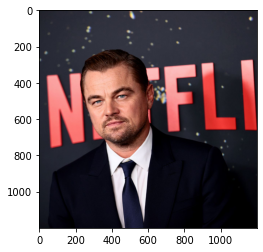

In [70]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
img_origin = cv2.imread(img_path)

print("img_origin_shape :", img_origin.shape)
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
plt.show()

- 아웃포커싱을 적용할 인물 사진을 불러옵니다.

### Model

In [71]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

In [72]:
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

- PixelLib 가 제공하는 모델의 url 입니다.

In [73]:
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fcb1794dd30>)

- 모델을 다운로드 하였습니다.

In [74]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

- pascalvoc 데이터로 학습된 모델을 이용하도록 하겠습니다.

In [75]:
segvalues, output = model.segmentAsPascalvoc(img_path)

- pascalvoc 로 학습된 모델에 원본 이미지를 적용하였습니다.

In [76]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

- pascalvoc data 의 라벨 종류는 21 가지로 위와 같습니다.

### Output

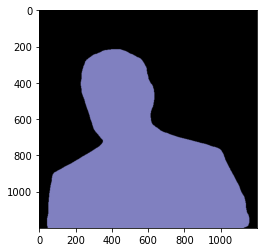

In [77]:
plt.imshow(output)
plt.show()

- 모델에서 나온 출력값 중 output 입니다.
- 사람의 영역이 올바르게 추출된 것으로 보입니다.

In [78]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

- 모델에서 나온 출력값 중 segvalues 입니다.

In [79]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


- class_ids 에서는 background 와 person 을 추출했음을 확인할 수 있습니다.

In [80]:
segvalues['masks'].shape

(1200, 1200)

- masks 에서는 채널 수가 사라지고 추출한 객체에 대한 픽셀별 값이 담겨있습니다.

### Mask

In [81]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- output 에서 잡아낸 객체마다 어떤 색상으로 표현하였는지 확인해보겠습니다.

In [82]:
colormap[15]

array([192, 128, 128])

- person 객체는 BGR 기준 (192, 128, 128) 의 색상을 사용하였음을 확인하였습니다.

In [83]:
seg_color = (128, 128, 192)

- 따라서, person 객체를 추출하기 위해서는 RGB 기준 (128, 128, 192) 의 색상을 사용하여야 합니다.

### Extract Mask

seg_map.shape : (1200, 1200)


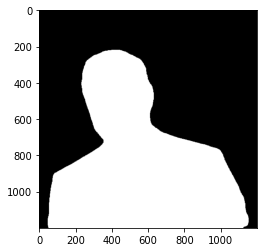

In [84]:
seg_map = np.all(output == seg_color, axis=-1)
print("seg_map.shape :", seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

- 앞서 정의한 person 객체의 seg_color 와 output 을 비교하였습니다.
- np.all 조건문을 활용해 seg_color 와 같은 값을 가지는 요소를 추출하였습니다.
- 조건문을 사용함에 따라, person 은 1(True), 그 외는 0(False) 로 표현되었습니다.

In [85]:
img_mask = seg_map.astype(np.uint8) * 255

- seg_map 의 각 값에 255 를 곱해준 뒤 img_mask 에 담아주었습니다.
- 따라서, img_mask 의 값은 0 또는 255 입니다.

In [86]:
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_mask 의 값들을 적당한 색상으로 바꿔주었습니다.

In [87]:
img_show = img_origin.copy()
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

- 실제 이미지 0.6, Mask 는 0.4 의 비율로 합쳐주었습니다.
- 결과는 아래와 같습니다.

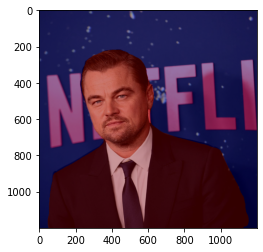

In [88]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 추출된 person 영역이 Mask 로 잘 추출되었습니다.

### BG_Blur

- person 을 추출했으니 background 를 blur 처리하여야 합니다.
- blur() 함수를 사용합니다.

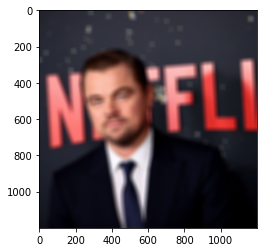

In [89]:
img_origin_blur = cv2.blur(img_origin, (32, 32))
plt.imshow(cv2.cvtColor(img_origin_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 원본 이미지를 blur 처리하여 img_origin_blur 에 담아주었습니다.
- (32, 32) 는 blurring kernal size 를 뜻하며 blur 의 정도를 의미합니다.

### Extract BG Mask

- blur 처리된 이미지에서 background 를 추출하여야 합니다.
- 앞서 정의한 img_mask 를 활용합니다.
- img_mask 는 person 을 255, 그 외를 0 으로 표현하고 있습니다.

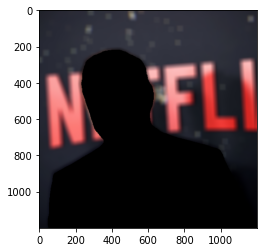

In [90]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_origin_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- img_mask 에 bitwise_not 연산으로 person 을 0, 그 외를 255 로 바꾸어줍니다.
- 이를 원본 이미지를 blur 처리한 img_bg_blur 와 bitwise_and 연산을 취해줍니다.
- person 은 0 이므로, 어떠한 값과 and 연산을 취하더라도 0 이 반환됩니다.
- 그에 반해, bg 는 255 의 값이므로 and 연산의 결과값이 출력됩니다.
- 결론적으로, person 은 0, bg 는 blur 처리된 값을 반환합니다.

### Concatenate

- 이제 앞서 extract한 blurred bg 와 원본 이미지를 결합하는 일이 남았습니다.

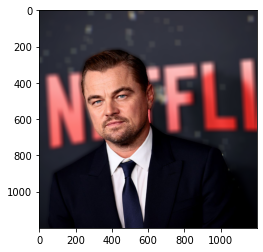

In [91]:
img_concat = np.where(img_bg_blur==0, img_origin, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- np.where 를 활용하여 img_bg_blur 에서 0 인 person 부분에는 원본 이미지를 출력하고, 그 외에는 img_bg_blur 를 출력하도록 하였습니다.
- 아래는 원본이미지입니다. 차이를 쉽게 비교하실 수 있습니다.

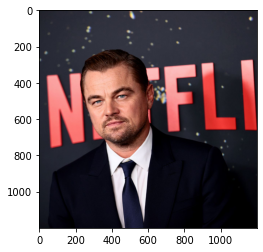

In [92]:
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
plt.show()

# 1.2) Source Code - Cat

### Load Image

img_origin_shape : (667, 1000, 3)


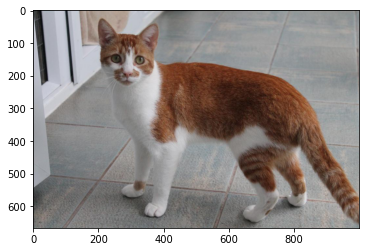

In [93]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.png'
img_origin = cv2.imread(img_path)

print("img_origin_shape :", img_origin.shape)
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
plt.show()

### Model

In [94]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)

- 고양이 이미지를 불러와 모델에 넣어주었습니다.

In [95]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

- 고양이는 LABEL_NAMES 에서 8 번 인덱스에 위치하고 있습니다.
- Output 을 확인해보겠습니다.

### Output

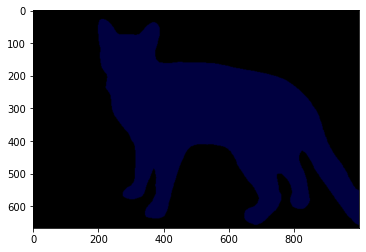

In [96]:
plt.imshow(output)
plt.show()

- 고양이가 잘 추출된 것으로 보입니다.

In [97]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

- 0 은 bg, 8 은 고양이로 잘 추출되었습니다.

In [98]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [99]:
segvalues['masks'].shape

(667, 1000)

### Mask

In [100]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [101]:
colormap[8]

array([64,  0,  0])

- 고양이 객체는 RGB 기준 (0, 0, 64) 의 색상값으로 표현되었음을 알 수 있습니다.

In [102]:
seg_color = (0, 0, 64)

### Extract Mask

seg_map.shape : (667, 1000)


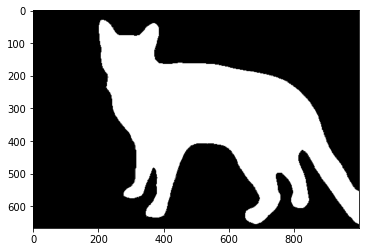

In [103]:
seg_map = np.all(output == seg_color, axis=-1)
print("seg_map.shape :", seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

- 고양이 영역을 1(True), 그 외를 0(False) 로 표현해주었습니다.

In [104]:
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

- 고양이 영역을 255, 그 외를 0 으로 변환한 뒤, 이를 적당한 색상값으로 변경해주었습니다.

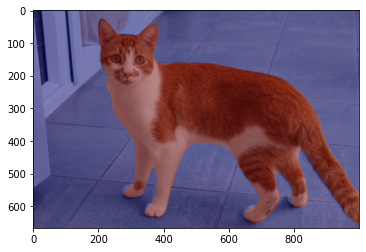

In [105]:
img_show = img_origin.copy()
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 고양이 영역이 잘 추출된 것을 확인할 수 있습니다.

### BG_Blur

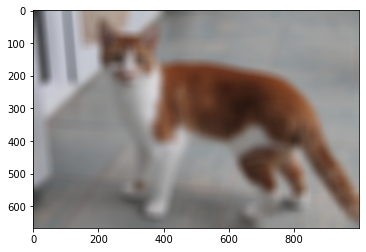

In [106]:
img_origin_blur = cv2.blur(img_origin, (32, 32))

plt.imshow(cv2.cvtColor(img_origin_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Extract BG Mask

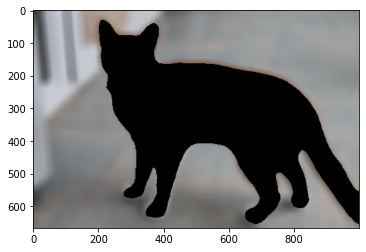

In [107]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_origin_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Concatenate

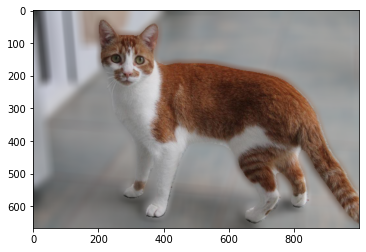

In [108]:
img_concat = np.where(img_bg_blur==0, img_origin, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

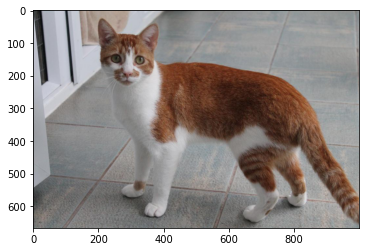

In [109]:
plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
plt.show()

- 원본 이미지와 비교하여 Out Of Focusing 이 잘 수행된 것을 확인할 수 있습니다.

# 1.3) Source Code - Chromakey

- 피사체를 추출해 다른 배경에 덮어쓰는 크로마키 기법을 구현해보겠습니다.

### Load Image

obj_origin_shape : (942, 500, 3)


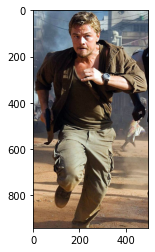

In [110]:
obj_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/leo_image.png'
obj_origin = cv2.imread(obj_img_path)

print("obj_origin_shape :", obj_origin.shape)
plt.imshow(cv2.cvtColor(obj_origin, cv2.COLOR_BGR2RGB))
plt.show()

- obj_origin 은 피사체 이미지입니다.

bg_origin_shape : (1050, 1680, 3)


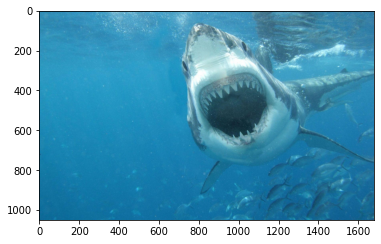

In [111]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/shark_image.png'
bg_origin = cv2.imread(bg_img_path)

print("bg_origin_shape :", bg_origin.shape)
plt.imshow(cv2.cvtColor(bg_origin, cv2.COLOR_BGR2RGB))
plt.show()

- bg_origin 은 배경 이미지입니다.

### Model

In [112]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
obj_segvalues, obj_output = model.segmentAsPascalvoc(obj_img_path)

- obj_origin 을 모델에 넣어주었습니다.

In [113]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

21

### Output

- Output 을 확인해보겠습니다.

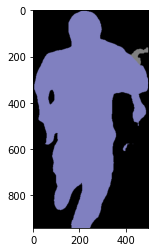

In [114]:
plt.imshow(obj_output)
plt.show()

In [115]:
obj_segvalues

{'class_ids': array([ 0,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

- 0 (background), 7 (car), 15 (person) 이 추출되었습니다.
- 이 중에서는 15 (person) 만을 추출하여 사용할 것입니다.

In [116]:
for class_id in obj_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car
person


In [117]:
obj_segvalues['masks'].shape

(942, 500)

### Mask

In [118]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [119]:
colormap[15]

array([192, 128, 128])

- 15 번 인덱스인 person object 는 RGB 기준 (128, 128, 192) 의 색상값으로 표현되었습니다.

In [120]:
obj_seg_color = (128, 128, 192)

### Extract Mask

obj_seg_map.shape : (942, 500)


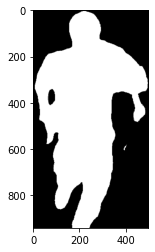

In [121]:
obj_seg_map = np.all(obj_output == obj_seg_color, axis=-1)
print("obj_seg_map.shape :", obj_seg_map.shape)

plt.imshow(obj_seg_map, cmap='gray')
plt.show()

- obj_seg_map 에서 person 영역은 1 (True), 그 외는 0 (False) 로 표현되었습니다.
- 함께 포착된 car 영역은 제거되었습니다.

In [122]:
obj_img_mask = obj_seg_map.astype(np.uint8) * 255
obj_color_mask = cv2.applyColorMap(obj_img_mask, cv2.COLORMAP_JET)

- person 영역은 255, 그 외는 0 으로 바꾸어주었습니다.
- 이후, 적당한 색을 적용해주었습니다.

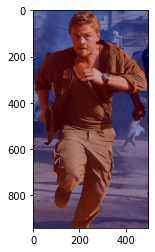

In [123]:
obj_origin_show = obj_origin.copy()
obj_origin_show = cv2.addWeighted(obj_origin_show, 0.6, obj_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(obj_origin_show, cv2.COLOR_BGR2RGB))
plt.show()

- person 영역이 잘 추출된 것을 확인할 수 있습니다.

### BG Image

In [124]:
obj_img_mask_color = cv2.cvtColor(obj_img_mask, cv2.COLOR_GRAY2BGR)
obj_mask = cv2.bitwise_not(obj_img_mask_color)

- not 연산을 취하여 person 은 0, 그 외는 255 로 바꾸어주었습니다.

In [125]:
obj_area = bg_origin[:obj_origin.shape[0],
                     :obj_origin.shape[1]]

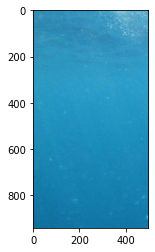

In [126]:
plt.imshow(cv2.cvtColor(obj_area, cv2.COLOR_BGR2RGB))
plt.show()

- background 에서 person object 를 붙일 공간을 선언해주었습니다.
- background image 와 person image 의 크기가 다르기 때문에 직접적으로 비트연산을 수행할 수 없어 area 를 따로 선언해주었습니다.

In [127]:
bg_show = bg_origin.copy()

- 원본 이미지를 bg_show 로 불러옵니다.

In [128]:
bg_show[:obj_origin.shape[0],
        :obj_origin.shape[1]] = \
    np.where(obj_mask==0, obj_origin, obj_area).astype(np.uint8)

- obj_mask 는 person 영역이 0, 그 외 영역이 255 인 mask 입니다.
- bg_show의 앞서 정의한 공간에서 obj_mask 가 0 이라면, 피사체의 원본 이미지를 붙입니다.
- 반대로, obj_mask 가 255 라면, 위에서 잘라낸 obj_area 를 붙입니다.

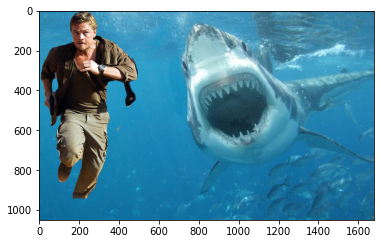

In [129]:
plt.imshow(cv2.cvtColor(bg_show, cv2.COLOR_BGR2RGB))
plt.show()

- 사진이 잘 합성되었지만, 위치를 조정해줄 필요가 있습니다.
- 이를 위해서 위치를 다시 지정해주도록 하겠습니다.

In [130]:
height_diff = bg_origin.shape[0] - obj_origin.shape[0]
height_diff

108

- 피사체를 아래로 내려주기 위해, 피사체와 배경의 높이 차이를 구합니다.

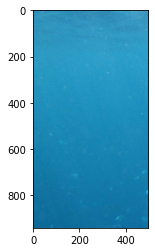

In [131]:
obj_area = bg_origin[height_diff:,
                     :obj_origin.shape[1]]

plt.imshow(cv2.cvtColor(obj_area, cv2.COLOR_BGR2RGB))
plt.show()

- height_diff 를 토대로 피사체를 붙일 공간, obj_area 를 다시 정의합니다.

In [132]:
bg_show = bg_origin.copy()

In [133]:
bg_show[height_diff:,
        :obj_origin.shape[1]] = \
    np.where(obj_mask==0, obj_origin, obj_area).astype(np.uint8)

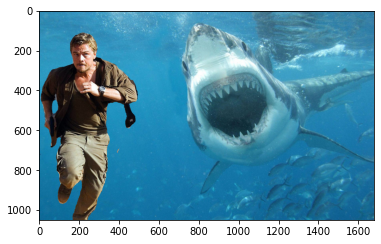

In [134]:
plt.imshow(cv2.cvtColor(bg_show, cv2.COLOR_BGR2RGB))
plt.show()

- 피사체가 정상적으로 위치하였습니다.

# 2) Retrospection